<a href="https://colab.research.google.com/github/BehnoodRasti/SparseEDAA/blob/main/SparseEDAA_Alex_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git
!git clone https://github.com/BehnoodRasti/SUnCNN.git

'git' is not recognized as an internal or external command,
operable program or batch file.
'git' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
!pip install munkres

In [59]:
import time
import os

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import numpy.linalg as LA
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

from munkres import Munkres
from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SAD 
from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner
from IPython.display import clear_output
import sys

In [60]:
import scipy.io
import numpy as np
fname2  = "SUnCNN/Data/DC2/Y_clean.mat"
mat2 = scipy.io.loadmat(fname2)
img_np_gt = mat2["Y_clean"]
img_np_gt = img_np_gt.transpose(2,0,1)
[p1, nr1, nc1] = img_np_gt.shape
img_resh=np.reshape(img_np_gt,(p1,nr1*nc1))
#%%
fname3  = "SUnCNN/Data/DC2/XT.mat"
mat3 = scipy.io.loadmat(fname3)
A_true_np = mat3["XT"]

#%%
fname4  = "SUnCNN/Data/DC2/EE.mat"
mat4 = scipy.io.loadmat(fname4)
EE = mat4["EE"]
D=EE
#%%
p = 9 # number of endmembers

In [61]:
img_np_gt.shape

(224, 100, 100)

In [62]:
img_resh.shape

(224, 10000)

In [63]:
img_resh.min()

0.02272115275293592

In [64]:
img_resh.max()

0.9662235319076795

In [65]:
LA.norm(img_resh, axis=0, ord=2, keepdims=True)

array([[11.56611384, 12.160922  , 12.08783926, ..., 10.93499974,
        11.05023039, 10.98190166]])

In [66]:
Y = img_resh

In [67]:
L, N = Y.shape

In [68]:
indices = np.random.choice(np.arange(N), size=100)

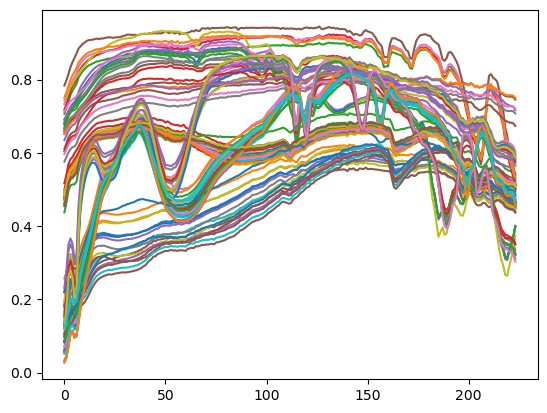

In [69]:
plt.plot(img_resh[:, indices]);

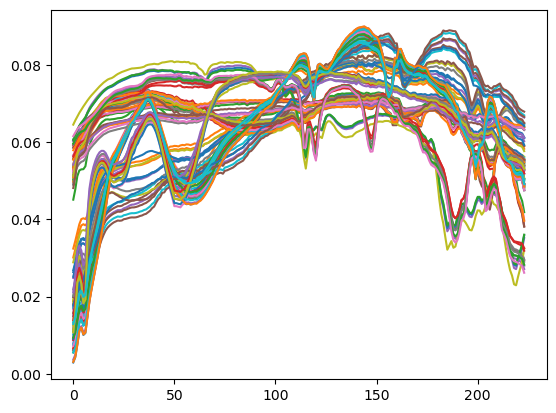

In [70]:
Y = Y / LA.norm(Y, axis=0, ord=2, keepdims=True)
plt.plot(Y[:, indices]);

In [71]:
# !pip install cvxpylayers

In [72]:
# import cvxpy as cp
# import torch
# from cvxpylayers.torch import CvxpyLayer

# p, N = 4, 100
# LibS=220
# x = cp.Variable((p,N))
# AA = cp.Parameter((LibS, p))
# bb = cp.Parameter((LibS,N))
# onesp=torch.ones((p,1))#.to(self.device) 
# onesn=torch.ones((N,1))#.to(self.device) 
# constraints = [onesp.t()@x == onesn.t()]
# objective = cp.Minimize(0.5 * cp.pnorm((AA @ x - bb)**2, p=2))
# problem = cp.Problem(objective, constraints)
# assert problem.is_dpp()

# cvxpylayer = CvxpyLayer(problem, parameters=[AA, bb], variables=[x])
# A_tch = torch.randn(LibS, p, requires_grad=True)
# b_tch = torch.randn(LibS,N, requires_grad=True)

# # solve the problem
# solution, = cvxpylayer(A_tch, b_tch,'ignore_dpp = True')
# print(solution)
# # compute the gradient of the sum of the solution with respect to A, b
# solution.sum().backward()

In [73]:
class SparseEDAA:
    def __init__(self, T=100, K1=5, K2=5, M=50):
        self.T = T
        self.K1 = K1
        self.K2 = K2
        self.M = M

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def solve(
        self,
        Y,
        D,
        p,
        seed=0,
        **kwargs,
    ):
        best_E = None
        best_A = None
        U1, Sig1, U1T = torch.linalg.svd(D.t()@ D, full_matrices=False)
        
        L, N = Y.shape
        LibS=D.shape[1]
        def residual(a, b):
            return 0.5 * ((Y - (D @ b) @ a) ** 2).sum()

        def residual_l1(a, b):
            return (Y - (D @ b) @ a).abs().sum()

        def lossTot(a, b, lamb):
            return residual(a, b) + lamb * b.abs().sum()
        
        def loss(a, b):
            return residual(a, b)
        def grad_A(a, b, S2, L2):
            #DB = D @ b
            #ret = -DB.t() @ (Y - DB @ a)
            return -mu2*B.t() @ (S2 - B @ A - L2)
#        def grad_A(a, b):
#            DB = D @ b
#            ret = -DB.t() @ (Y - DB @ a)
#            return ret
        def grad_B(a, b, lamb):
            return -D.t() @ ((Y - D @ b @ a) @ a.t())+lamb*torch.sign(b)

#        def update(a, b,c):
#            return F.softmax(a*torch.exp(-c*b), dim=0)#F.softmax(torch.log(a) + b, dim=0)
#        def update(a, b):
#            return F.softmax(torch.log(a) + b, dim=0)
        def update(a, b,c, nu):
            return a*torch.exp(-c*b)*torch.exp(-c*nu-1)       
        def updateB(a, b):
            return a * b
        
        def computeLA(a, b):
            DB = D @ b
            S = torch.linalg.svdvals(DB)
            return S[0] * S[0]

        max_correl = lambda e: np.max(np.corrcoef(e.T) - np.eye(p))

        results = {}
        eps=sys.float_info.epsilon
        tic = time.time()

        for m in tqdm(range(self.M)):
            torch.manual_seed(m + seed)
            generator = np.random.RandomState(m + seed)

            with torch.no_grad():

                # Matrix initialization
                #B = torch.rand((LibS, p))
                #B = F.softmax(0.008*torch.rand((LibS, p)), dim=0)
                # B = F.softmax(torch.rand((LibS, p)), dim=0)
                A = (1 / p) * torch.ones((p, N))
                B=A
                L1 = torch.zeros((p,N))
                L2 = torch.zeros((LibS,p))
                L3 = torch.zeros((L,p))
                #B = F.softmax(torch.rand((LibS, LibS)), dim=0)
                #A = (1 / p) * torch.ones((LibS, N))
                #L1 = torch.zeros((LibS,LibS))
                S1=L1
                S2=L2
                S3=L3
                #Sig2=torch.zeros((LibS,LibS))
                Sig2=torch.zeros((p,p))
                U2=Sig2
                U2T=Sig2
                inv1=torch.zeros((p,p))
                inv2=torch.zeros((1,1))
                inv3=torch.zeros((LibS,LibS))
                inv4=inv2
                inv5=torch.zeros((LibS,LibS))
                # Send matrices on GPU
                D = D.to(self.device)
                Y = Y.to(self.device)
                A = A.to(self.device)
                B = B.to(self.device)
                S1 = S1.to(self.device)
                S2 = S2.to(self.device)
                S3 = S3.to(self.device)
                L1 = L1.to(self.device)
                L2 = L2.to(self.device)
                L3 = L3.to(self.device)
                #Sig1 = Sig1.to(self.device)
                U1 = U1.to(self.device)
                U1T = U1T.to(self.device)
                U2 = U2.to(self.device)
                U2T = U2T.to(self.device)
                Sig2 = Sig2.to(self.device)
                inv1 = inv1.to(self.device)
                inv2 = inv2.to(self.device)
                inv3 = inv3.to(self.device)
                inv4 = inv4.to(self.device)
                inv5 = inv5.to(self.device)
                eyep=torch.eye(p).to(self.device) 
                eyeLibS=torch.eye(LibS).to(self.device) 
                onesp=torch.ones((p,1)).to(self.device) 
                onesLibS=torch.ones((LibS,1)).to(self.device) 
                onesn=torch.ones((N,1)).to(self.device) 
                eyeL=torch.eye(L).to(self.device) 
                # Random Step size factor
                self.lamb =.001
                mu1=20
                mu2=10
                mu3=1
                nu=.9
                soft=torch.nn.Softshrink(self.lamb/mu2)
                hard=torch.nn.Hardshrink(self.lamb/mu2)
                DtY=D.t()@Y
                inv3=torch.inverse(mu3*D.t()@D+mu2*eyeLibS)#+eyeLibS*eps)
                inv4=-1/(onesLibS.t()@inv3@onesLibS)
                #============
                inv5=torch.inverse(mu2*eyeLibS+mu3*D.t()@D)
                for ii in range(self.T):
                    for kk in range(self.K1):
                        inv1=torch.inverse(mu3*S3.t()@S3+mu1*eyep)
                        inv2=-1/(onesp.t()@inv1@onesp)
                        A=(inv1+inv1@onesp@inv2@onesp.t()@inv1)@(S3.t()@Y+mu1*(S1-L1))-inv1@onesp@(inv2*onesn.t())
                        #B=(inv3+inv3@onesLibS@inv4@onesLibS.t()@inv3)@(mu3*D.t()@(S3-L3)+mu2*(S2-L2))-inv3@onesLibS@(inv4*onesp.t())
                        B=inv5@(mu2*(S2-L2)+mu3*D.t()@(S3-L3))
                        S3=(Y@A.t() + mu3*(D@B+L3))@torch.inverse(A@A.t()+mu3*eyep)
                        S1= (A+L1)
                        S1[S1<=0]=0
                        #S2= (B+L2)
                        #============
                        S2= soft(B+L2)
                        S2[S2<=0]=0
                        #===========
                        S2[S2>=1]=1
                        #===========
                        L1 = L1 + A - S1
                        L2 = L2 + B - S2
                        L3 = L3 + D@B - S3
                        print(lossTot(A,B,self.lamb).item())
                    if ii % 1000 == 0:
                            clear_output(wait=False)
                #fit_m = residual_l1(A, B).item()
                E = (D @ B).cpu().numpy()
                A = A.cpu().numpy()
                Xmap = B.t().cpu().numpy()
                #Rm = max_correl(E)
                # Store results
                results[m] = {
                    #"Rm": Rm,
                    "Em": E,
                    "Am": A,
                    "Bm": Xmap,
                    #"fit_m": fit_m,
                    #"factA": factA,
                }

        #min_fit_l1 = np.min([v["fit_m"] for k, v in results.items()])

        #def fit_l1_cutoff(idx, tol=0.05):
        #    val = results[idx]["fit_m"]
        #    return (abs(val - min_fit_l1) / abs(val)) < tol

        #sorted_indices = sorted(
        #    filter(fit_l1_cutoff, results),
        #    key=lambda x: results[x]["Rm"],
        #)

        #best_result_idx = sorted_indices[0]
        #best_result = results[best_result_idx]

        #best_E = best_result["Em"]
        #best_A = best_result["Am"]
        self.Xmap = Xmap# best_result["Bm"]

        toc = time.time()
        elapsed_time = round(toc - tic, 2)
        print(f"{self} took {elapsed_time}s")

        return B.cpu().numpy(), E, A

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

In [74]:
import numpy as np


class AdditiveWhiteGaussianNoise:
    def __init__(self):
        self.sigmas = None
        self.SNR = None
        self.L = None
        self.N = None

    def fit(self, Y, SNR: float):
        """
        Compute sigmas at the desired SNR given a flattened input HSI Y
        """
        assert len(Y.shape) == 2
        self.L, self.N = Y.shape
        #logger.debug(f"Y shape: {Y.shape}")
        self.SNR = SNR
        #logger.debug(f"Desired SNR: {self.SNR}")

        if SNR is None:
            self.sigmas = np.zeros(self.L)
        else:
            assert SNR > 0, "SNR must be stricly positive"
            # Uniform across bands
            sigmas = np.ones(self.L)
            # Normalization
            sigmas /= np.linalg.norm(sigmas)
            #logger.debug(f"Sigmas after normalization: {sigmas[0]}")
            # compute mean sigma
            num = np.sum(Y ** 2) / self.N
            denom = 10 ** (self.SNR / 10)
            sigmas_mean = np.sqrt(num / denom)
            #logger.debug(f"Sigma mean based on SNR: {sigmas_mean}")
            # Noise variance
            sigmas *= sigmas_mean
            #logger.debug(f"Final sigmas value: {sigmas[0]}")
            self.sigmas = sigmas

    def transform(self, Y, seed=0):
        """
        Add White Gaussian Noise to the flattened input HSI Y
        """
        assert self.sigmas is not None, "Must be fitted first"
        assert (self.L, self.N) == Y.shape
        # Fix random seed
        generator = np.random.RandomState(seed=seed)
        # Noise generation
        N = np.diag(self.sigmas) @ generator.randn(self.L, self.N)
        # Additive Noise
        return Y + N

    def fit_transform(self, Y, SNR, seed=0):
        """
        Combine `fit` and `transform` methods.
        See above for their respective usage.
        """
        self.fit(Y, SNR)
        return self.transform(Y, seed=seed)

In [75]:
# # Subspace Setup
# from scipy import linalg
# model = SparseEDAA(K1=1, K2=1, T=20000, M=1)
# #Y = img_resh
# D=EE
# #img_mean=np.mean(img_resh,1).reshape(p1,1)
# #img_mean_rmv=img_resh-img_mean
# #V, SS, U = scipy.linalg.svd(img_mean_rmv@img_mean_rmv.transpose(1,0)/(nr1*nc1), full_matrices=False)
# #Y=V[:,:p].transpose(1,0)@img_mean_rmv
# Y = noise.fit_transform(img_resh, SNR=40, seed=0)
# V, SS, U = scipy.linalg.svd(Y, full_matrices=False)
# Y_r=V[:,:p].transpose(1,0)@Y
# DD = V[:,:p].transpose(1,0)@D
# noise = AdditiveWhiteGaussianNoise()
# Y_r = torch.Tensor(Y_r)
# DD = torch.Tensor(DD)
# D = torch.Tensor(D)
# E00, A0 = model.solve(Y_r, DD, p, seed=1)
# E0=V[:,:p]@E00

In [76]:
# Instantiate objects
model = SparseEDAA(K1=1, K2=1, T=20000, M=1)
Y = img_resh
D = EE#np.concatenate((EE, Y), axis=1)
# Call data to return HSI (numpy format)
#Y, _, _ = hsi()

# l2-normalize the data
#Y = Y / LA.norm(Y, axis=0, ord=2, keepdims=True)

noise = AdditiveWhiteGaussianNoise()

Y = noise.fit_transform(Y, SNR=40, seed=0)

from scipy import linalg
V, SS, U = scipy.linalg.svd(Y, full_matrices=False)
PC=np.diag(SS)@U
Y_DN=V[:,:p]@PC[:p,:]
#D = D / LA.norm(D, axis=0, ord=2, keepdims=True)
#D=Y
# Convert the data to tensors
Y = torch.Tensor(Y)
Y_DN = torch.Tensor(Y_DN)
D = torch.Tensor(D)
# Abundances estimation
B0, E0, A0 = model.solve(Y_DN, D, p, seed=1)

# Plot results
#hsi.plot_endmembers(E0=E0)
#hsi.plot_abundances(A0=A0)

0.5730544924736023
0.573074996471405
0.5731215476989746
0.5730615258216858
0.5729914307594299
0.5731589198112488
0.5729422569274902
0.5728989839553833
0.5732914805412292
0.5729223489761353
0.57314532995224
0.5729961395263672
0.5729553699493408
0.5730516314506531
0.572961688041687
0.5729495286941528
0.5728888511657715
0.5730495452880859
0.5728580951690674
0.5730748772621155
0.5728838443756104
0.5729135274887085
0.5729338526725769
0.5729491114616394
0.572878360748291
0.5731164813041687
0.5729115605354309
0.5729316473007202
0.5729051828384399
0.5730600357055664
0.572850227355957
0.5728982090950012
0.5728234052658081
0.5729753375053406
0.5729145407676697
0.5727607011795044
0.5730386972427368
0.5727579593658447
0.572978675365448
0.5727916359901428
0.5730859041213989
0.5728392004966736
0.5728829503059387
0.5729503631591797
0.5727869868278503
0.5728404521942139
0.5727184414863586
0.5729443430900574
0.5727468132972717
0.572893500328064
0.5727084875106812
0.5728161334991455
0.5728694200515747
0

In [77]:
print(N)

10000


In [78]:
D = torch.Tensor(D)
Y = img_resh

In [79]:
img_mean=np.mean(img_resh,1).reshape(p1,1)
img_mean_rmv=img_resh-img_mean
V, SS, U = scipy.linalg.svd(img_mean_rmv@img_mean_rmv.transpose(1,0)/(nr1*nc1), full_matrices=False)
Y=V[:,:p]@V[:,:p].transpose(1,0)@img_mean_rmv
Y.shape

(224, 10000)

In [80]:
(D.t() @ Y ).shape

torch.Size([240, 10000])

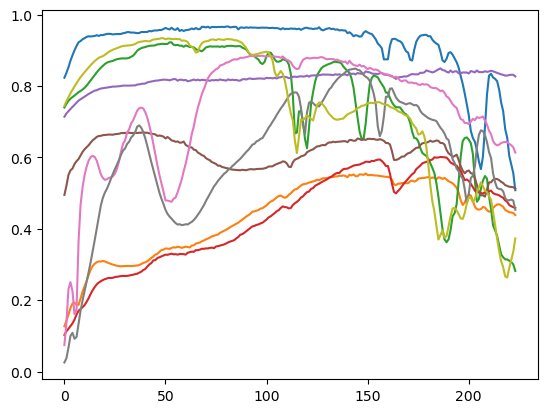

In [81]:
plt.plot(E0)

In [82]:
model.Xmap.shape

(9, 240)

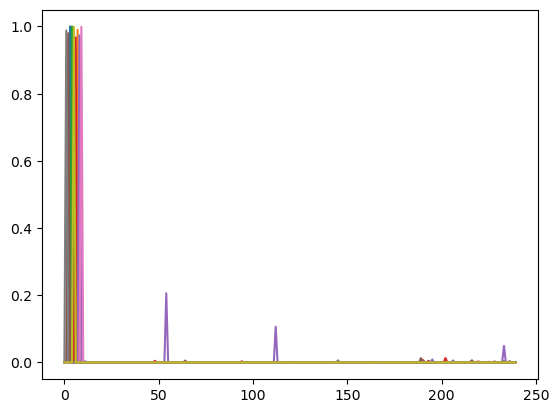

In [83]:
plt.plot(model.Xmap.T)

In [84]:
model.Xmap.min()

-4.7683716e-06

In [85]:
model.Xmap.max()

1.0000029

In [86]:
model.Xmap.sum(1)

array([1.0030515, 1.0053413, 1.0015625, 1.0100253, 1.3658732, 1.0194746,
       1.0015703, 1.007006 , 1.0003808], dtype=float32)

In [87]:
import numpy as np
from munkres import Munkres

class BaseAbundancesAligner2:
    def __init__(self, A, criterion):
        self.Aref = A
        self.criterion = criterion
        self.P = None
        self.dists = None

    def fit(self, A):
        raise NotImplementedError

    def transform(self, A):
        assert self.P is not None, "Must be fitted first"
        assert A.shape[0] == self.P.shape[0]
        assert A.shape[0] == self.P.shape[1]

        return self.P @ A

    def transform_endmembers(self, E):
        assert self.P is not None, "Must be fitted first"
        assert E.shape[1] == self.P.shape[0]
        assert E.shape[1] == self.P.shape[1]

        return E @ self.P.T

    def fit_transform(self, A):

        self.fit(A)
        res = self.transform(A)
        return res

    def __repr__(self):
        msg = f"{self.__class__.__name__}_crit{self.criterion}"
        return msg


class MunkresAbundancesAligner2(BaseAbundancesAligner2):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, A):

        # Computing distance matrix
        self.dists = self.criterion(A.T, self.Aref.T)

        # Initialization
        p = A.shape[0]
        P = np.zeros((p, p))

        m = Munkres()
        indices = m.compute(self.dists)
        for row, col in indices:
            P[row, col] = 1.0

        self.P = P.T

In [88]:
# Select a criterion to perform alignment
criterion = MSE()

# Select an aligner to perform alignment
A_true = A_true_np.reshape((EE.shape[1],nr1*nc1))#[1:p+1,:]
aligner = MunkresAbundancesAligner2(A=A_true, criterion=criterion)

#A1 = aligner.fit_transform(A0)
#E1 = aligner.transform_endmembers(E0)

#
#x = A0.astype(np.float32).reshape((EE.shape[1],nr1*nc1))
SRE = 20*np.log10(LA.norm(A_true,'fro')/LA.norm((A_true - B0@A0),'fro'))

print ('SRE: %f' % (SRE))




SRE: 21.508766


ValueError: cannot reshape array of size 2400000 into shape (9,100,100)

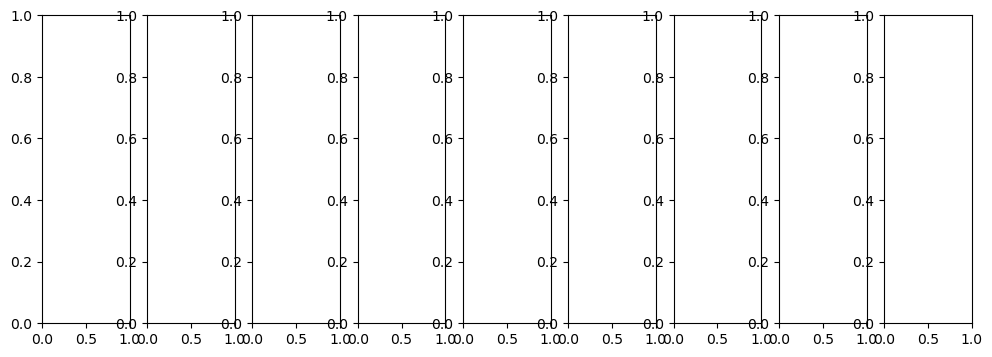

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=p, figsize=(12, 4))
A_reshape = A_true.reshape((p, nr1, nc1))
for kk in range(p):
    curr_ax = ax[kk]
    mappable = curr_ax.imshow(A_reshape[kk], vmin=0.0, vmax=1.0)
    fig.colorbar(mappable, ax=curr_ax, shrink=0.5)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=p, figsize=(12, 4))
A2 = A1.reshape((p, nr1, nc1))
for kk in range(p):
    curr_ax = ax[kk]
    mappable = curr_ax.imshow(A2[kk], vmin=0.0, vmax=1.0)
    fig.colorbar(mappable, ax=curr_ax, shrink=0.5)